Example of using conditional flows with `glasflow` using a dataset from `sklearn`

In [1]:
from glasflow import RealNVP
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import torch

torch.manual_seed(1451)
np.random.seed(1451)
plt.style.use('seaborn-colorblind')

Use `make_blobs` to make a set of Gaussian blobs corresponding to different classes.

In [2]:
data, labels = make_blobs(
    n_samples=10000,
    n_features=2,
    centers=4,
    cluster_std=[1.7, 5.0, 3.1, 0.2],
    random_state=314159
)
classes = np.unique(labels)
print(f'Classes are: {classes}')

Classes are: [0 1 2 3]


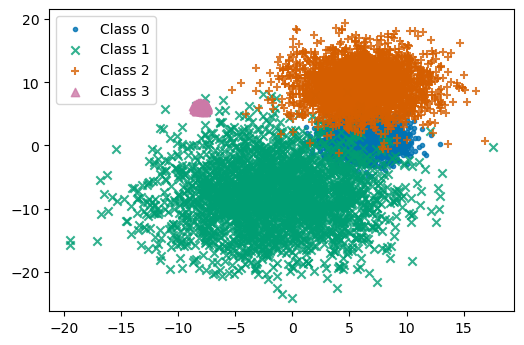

In [3]:
fig = plt.figure(dpi=100)
markers = ['.', 'x', '+', '^']
for c, m in zip(classes, markers):
    idx = (labels == c)
    plt.scatter(data[idx, 0], data[idx, 1], label=f'Class {c}', marker=m, alpha=0.8)
plt.legend()
plt.show()

In [4]:
device = 'cpu'
flow = RealNVP(
    n_inputs=2,
    n_transforms=4,
    n_conditional_inputs=1,
    n_neurons=32,
    batch_norm_between_transforms=True
)
flow.to(device)
print(f'Created flow and sent to {device}')

Created flow and sent to cpu


In [5]:
optimiser = torch.optim.Adam(flow.parameters())

In [6]:
batch_size = 1000
x_train, x_val, y_train, y_val = train_test_split(data, labels[:, np.newaxis])

Prepare the data using dataloaders

In [7]:
x_train_tensor = torch.from_numpy(x_train.astype(np.float32))
y_train_tensor = torch.from_numpy(y_train.astype(np.float32))
train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

x_val_tensor = torch.from_numpy(x_val.astype(np.float32))
y_val_tensor = torch.from_numpy(y_val.astype(np.float32))
val_dataset = torch.utils.data.TensorDataset(x_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

Train the flow.

In [8]:
epochs = 200
loss = dict(train=[], val=[])

for i in range(epochs):
    flow.train()
    train_loss = 0.0
    for batch in train_loader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        optimiser.zero_grad()
        _loss = -flow.log_prob(x, conditional=y).mean()
        _loss.backward()
        optimiser.step()
        train_loss += _loss.item()
    loss['train'].append(train_loss / len(train_loader))

    flow.eval()
    val_loss = 0.0
    for batch in val_loader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            _loss = -flow.log_prob(x, conditional=y).mean().item()
        val_loss += _loss
    loss['val'].append(val_loss / len(val_loader))
    if not i % 10:
        print(f"Epoch {i} - train: {loss['train'][-1]:.3f}, val: {loss['val'][-1]:.3f}")

flow.eval()
print('Finished training')

Epoch 0 - train: 7.508, val: 11.388
Epoch 10 - train: 5.354, val: 5.736
Epoch 20 - train: 4.299, val: 4.306
Epoch 30 - train: 4.038, val: 4.066
Epoch 40 - train: 3.952, val: 3.832
Epoch 50 - train: 3.951, val: 3.950
Epoch 60 - train: 3.875, val: 3.710
Epoch 70 - train: 3.992, val: 5.910
Epoch 80 - train: 3.934, val: 4.052
Epoch 90 - train: 3.877, val: 4.093
Epoch 100 - train: 3.796, val: 3.896
Epoch 110 - train: 3.767, val: 3.700
Epoch 120 - train: 3.807, val: 3.668
Epoch 130 - train: 3.849, val: 3.800
Epoch 140 - train: 3.742, val: 3.690
Epoch 150 - train: 3.924, val: 3.911
Epoch 160 - train: 3.757, val: 3.813
Epoch 170 - train: 3.753, val: 3.558
Epoch 180 - train: 3.738, val: 3.656
Epoch 190 - train: 3.765, val: 3.933
Finished training


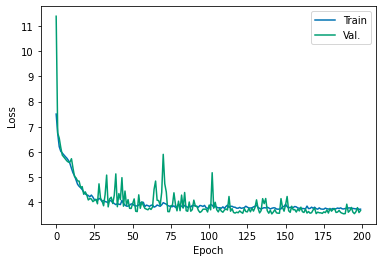

In [9]:
plt.plot(loss['train'], label='Train')
plt.plot(loss['val'], label='Val.')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
n = 10000
conditional = torch.from_numpy(np.random.choice(4, size=(n, 1)).astype(np.float32)).to(device)
with torch.no_grad():
    samples = flow.sample(n, conditional=conditional)
samples = samples.cpu().numpy()
conditional = conditional.cpu().numpy()

From the figure below we can see that the flow probably requires a bit more training but it does show how the flow can learn each distribution using the conditional inputs.

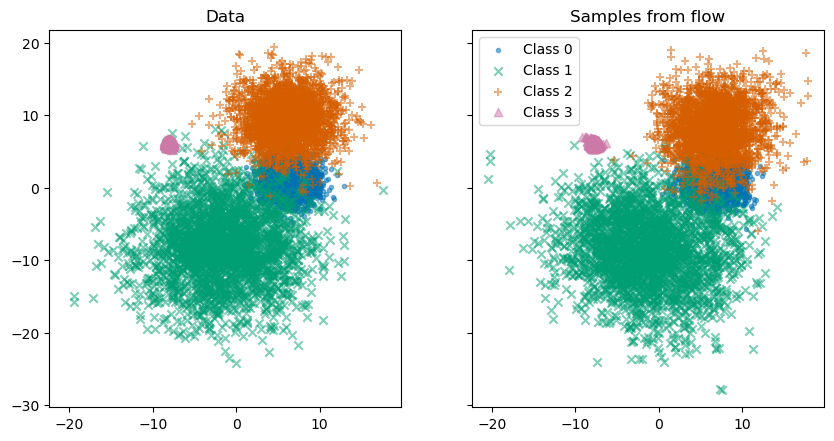

In [11]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5), dpi=100)
markers = ['.', 'x', '+', '^']
for c, m in zip(classes, markers):
    idx = (labels == c)
    ax[0].scatter(data[idx, 0], data[idx, 1], label=f'Class {c}', marker=m, alpha=0.5)
    
    idx = (conditional[:,0] == c)
    ax[1].scatter(samples[idx, 0], samples[idx, 1], label=f'Class {c}', marker=m, alpha=0.5)
ax[0].set_title('Data')
ax[1].set_title('Samples from flow')
plt.legend()
plt.show()